In [1]:
# Reload automatically when the file is changed.
%load_ext autoreload
%autoreload 2

# Importing Modules

In [2]:
import numpy as np
import torch
import time
import os
from sklearn import (linear_model, model_selection, preprocessing,
                     pipeline)
from scipy.spatial.distance import pdist
from kymatio.torch import HarmonicScattering3D
from kymatio.scattering3d.utils import generate_weighted_sum_of_gaussians
from kymatio.datasets import fetch_qm7
from kymatio.caching import get_cache_dir
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
# Import torch backend 
from kymatio.scattering3d.backend.torch_backend import TorchBackend3D
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, train_test_split
from tqdm.auto import tqdm


from sklearn.preprocessing import StandardScaler




import os 
import sys
MODULES_PATH = "../../Modules/Scattering"
MODELS_PATH = "../../Models/"

sys.path.append(MODULES_PATH)
sys.path.append(MODELS_PATH)


from Preprocessing import *
from Dataloaders_Preprocessing import *
from Features import *
from Verifying_Invariance import *
from Post_Train import *
from Train_Ridge import *

# Importing Data

In [3]:
List_Data_Train = Load_Data('../../Data/atoms/train', '../../Data/energies/train.csv')
List_Data_Test= Load_Test_Data('../../Data/atoms/test')

In [4]:
Display_Molecule_From_Atom_List(List_Data_Train[500]['Atoms_List'], Width=800, Height=800, Background_Color='lightblue')


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [5]:
Train_Dataset = XYZDataset_V2(List_Data_Train)
Test_Dataset = XYZDataset_V2(List_Data_Test,return_energy=False)

# Computing Scattering

In [6]:
LOAD_SCATTERING = True

In [7]:
def config(device):
    M = 192
    N = 128
    O = 96
    grid  = torch.tensor(np.fft.ifftshift(np.mgrid[-M//2:-M//2+M, -N//2:-N//2+N, -O//2:-O//2+O]))
    
    J =2
    L = 3
    sigma = 2.0
    integral_powers = [0.5, 1.0, 2.0, 3.0,5.0]
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    scattering = HarmonicScattering3D(J=J, shape=(M, N, O),
                                        L=L, sigma_0=sigma,
                                        integral_powers=integral_powers, max_order=2).to(device)
    
    return grid, scattering, sigma, integral_powers, M,N,O,J,L

In [8]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
# Define output directory and ensure it exists
output_dir_train = "../../Saved_Features/Scattering/Train"
os.makedirs(output_dir_train, exist_ok=True)

output_dir_test = "../../Saved_Features/Scattering/Test"
os.makedirs(output_dir_test, exist_ok=True)


In [10]:
if not LOAD_SCATTERING:

    order_0, orders_1_and_2 = [], []
    Ids = []
    energies = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    grid, scattering, sigma, integral_powers, M,N,O,J,L = config(device)

    test_loader = DataLoader(Test_Dataset, batch_size=16, shuffle=True)
    train_loader = DataLoader(Train_Dataset, batch_size=16, shuffle=True)


    import torch
    from tqdm.auto import tqdm
    import os

    # Assuming order_0, orders_1_and_2, and energies are lists
    order_0 = []
    orders_1_and_2 = []
    energies = []

    # Your existing loop
    for batch in tqdm(train_loader):
        Id_Batch = batch[0]
        full_charge_batch = batch[1]
        valence_batch = batch[2]
        pos_batch = batch[3]
        energie = batch[4]

        full_density_batch = generate_weighted_sum_of_gaussians(grid, pos_batch, full_charge_batch, sigma)
        full_density_batch = torch.from_numpy(full_density_batch)
        full_density_batch = full_density_batch.to(device).float()
        full_order_0 = TorchBackend3D.compute_integrals(full_density_batch, integral_powers)
        full_scattering = scattering(full_density_batch)

        val_density_batch = generate_weighted_sum_of_gaussians(grid, pos_batch, valence_batch, sigma)
        val_density_batch = torch.from_numpy(val_density_batch)
        val_density_batch = val_density_batch.to(device).float()
        val_order_0 = TorchBackend3D.compute_integrals(val_density_batch, integral_powers)
        val_scattering = scattering(val_density_batch)

        core_density_batch = full_density_batch - val_density_batch
        core_order_0 = TorchBackend3D.compute_integrals(core_density_batch, integral_powers)
        core_scattering = scattering(core_density_batch)

        batch_order_0 = torch.stack((full_order_0, val_order_0, core_order_0), dim=-1)
        batch_orders_1_and_2 = torch.stack((full_scattering, val_scattering, core_scattering), dim=-1)
        
        order_0.append(batch_order_0)
        orders_1_and_2.append(batch_orders_1_and_2)
        energies.append(energie)
        Ids.append(Id_Batch)
else:
    order_0_train = torch.load(os.path.join(output_dir_train, 'order_0.pt'))
    orders_1_and_2_train = torch.load(os.path.join(output_dir_train, 'orders_1_and_2.pt'))
    energies_train = torch.load(os.path.join(output_dir_train, 'energies.pt'))
    Ids_train = torch.load(os.path.join(output_dir_train, 'Ids.pt'))

    

# Sort Ids and corresponding data
sorted_indices = np.argsort(Ids_train)
order_0_train = order_0_train[sorted_indices]
orders_1_and_2_train = orders_1_and_2_train[sorted_indices]
energies_train = energies_train[sorted_indices]
Ids_train = Ids_train[sorted_indices]





/tmp/ipykernel_32888/2401869740.py:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  order_0_train = torch.load(os.path.join(output_dir_train, 'order_0.pt'))
/tmp/ipykernel_

In [11]:
if not LOAD_SCATTERING:
    order_0, orders_1_and_2 = [], []
    energies = []
    Ids = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    grid, scattering, sigma, integral_powers, M,N,O,J,L = config(device)

    test_loader = DataLoader(Test_Dataset, batch_size=16, shuffle=False)


    import torch
    from tqdm.auto import tqdm
    import os

    # Assuming order_0, orders_1_and_2, and energies are lists
    order_0 = []
    orders_1_and_2 = []
    energies = []

    # Your existing loop
    for batch in tqdm(test_loader):
        Id_batch = batch[0]
        full_charge_batch = batch[1]
        valence_batch = batch[2]
        pos_batch = batch[3]
        energie = 0

        full_density_batch = generate_weighted_sum_of_gaussians(grid, pos_batch, full_charge_batch, sigma)
        full_density_batch = torch.from_numpy(full_density_batch)
        full_density_batch = full_density_batch.to(device).float()
        full_order_0 = TorchBackend3D.compute_integrals(full_density_batch, integral_powers)
        full_scattering = scattering(full_density_batch)

        val_density_batch = generate_weighted_sum_of_gaussians(grid, pos_batch, valence_batch, sigma)
        val_density_batch = torch.from_numpy(val_density_batch)
        val_density_batch = val_density_batch.to(device).float()
        val_order_0 = TorchBackend3D.compute_integrals(val_density_batch, integral_powers)
        val_scattering = scattering(val_density_batch)

        core_density_batch = full_density_batch - val_density_batch
        core_order_0 = TorchBackend3D.compute_integrals(core_density_batch, integral_powers)
        core_scattering = scattering(core_density_batch)

        batch_order_0 = torch.stack((full_order_0, val_order_0, core_order_0), dim=-1)
        batch_orders_1_and_2 = torch.stack((full_scattering, val_scattering, core_scattering), dim=-1)
        
        order_0.append(batch_order_0)
        orders_1_and_2.append(batch_orders_1_and_2)
        energies.append(energie)
        Ids.append(Id_batch)
else:
    order_0_test = torch.load(os.path.join(output_dir_test, 'order_0.pt'))
    orders_1_and_2_test = torch.load(os.path.join(output_dir_test, 'orders_1_and_2.pt'))
    # energies_test = torch.load(os.path.join(output_dir_test, 'energies.pt'))
    Ids_test = torch.load(os.path.join(output_dir_test, 'Ids.pt'))

    
# Sort Ids and corresponding data
sorted_indices = np.argsort(Ids_test)
order_0_test = order_0_test[sorted_indices]
orders_1_and_2_test = orders_1_and_2_test[sorted_indices]
# energies_test = energies_test[sorted_indices]
Ids_test = Ids_test[sorted_indices]


/tmp/ipykernel_32888/277138961.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  order_0_test = torch.load(os.path.join(output_dir_test, 'order_0.pt'))
/tmp/ipykernel_328

# Ridge Regression

## Adding Features to the Scattering coefficients

In [12]:
ids_train, features_train = extract_features_and_ids(List_Data_Train)
ids_test, features_test = extract_features_and_ids(List_Data_Test)


In [13]:
# Transfer to CPU, to Numpy arrays, and flatten the tensors
order_0_train = order_0_train.reshape(order_0_train.shape[0], -1).cpu().numpy()
orders_1_and_2_train = orders_1_and_2_train.reshape(orders_1_and_2_train.shape[0], -1).cpu().numpy()
order_0_test = order_0_test.reshape(order_0_test.shape[0], -1).cpu().numpy()
orders_1_and_2_test = orders_1_and_2_test.reshape(orders_1_and_2_test.shape[0], -1).cpu().numpy()



# Concatenate the features with the scattering features
X_Train_With_Features = np.concatenate((features_train, order_0_train, orders_1_and_2_train), axis=1)
X_Test_With_Features = np.concatenate((features_test, order_0_test, orders_1_and_2_test), axis=1)

                                       

## Visualizing the Scattering coefficients

Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


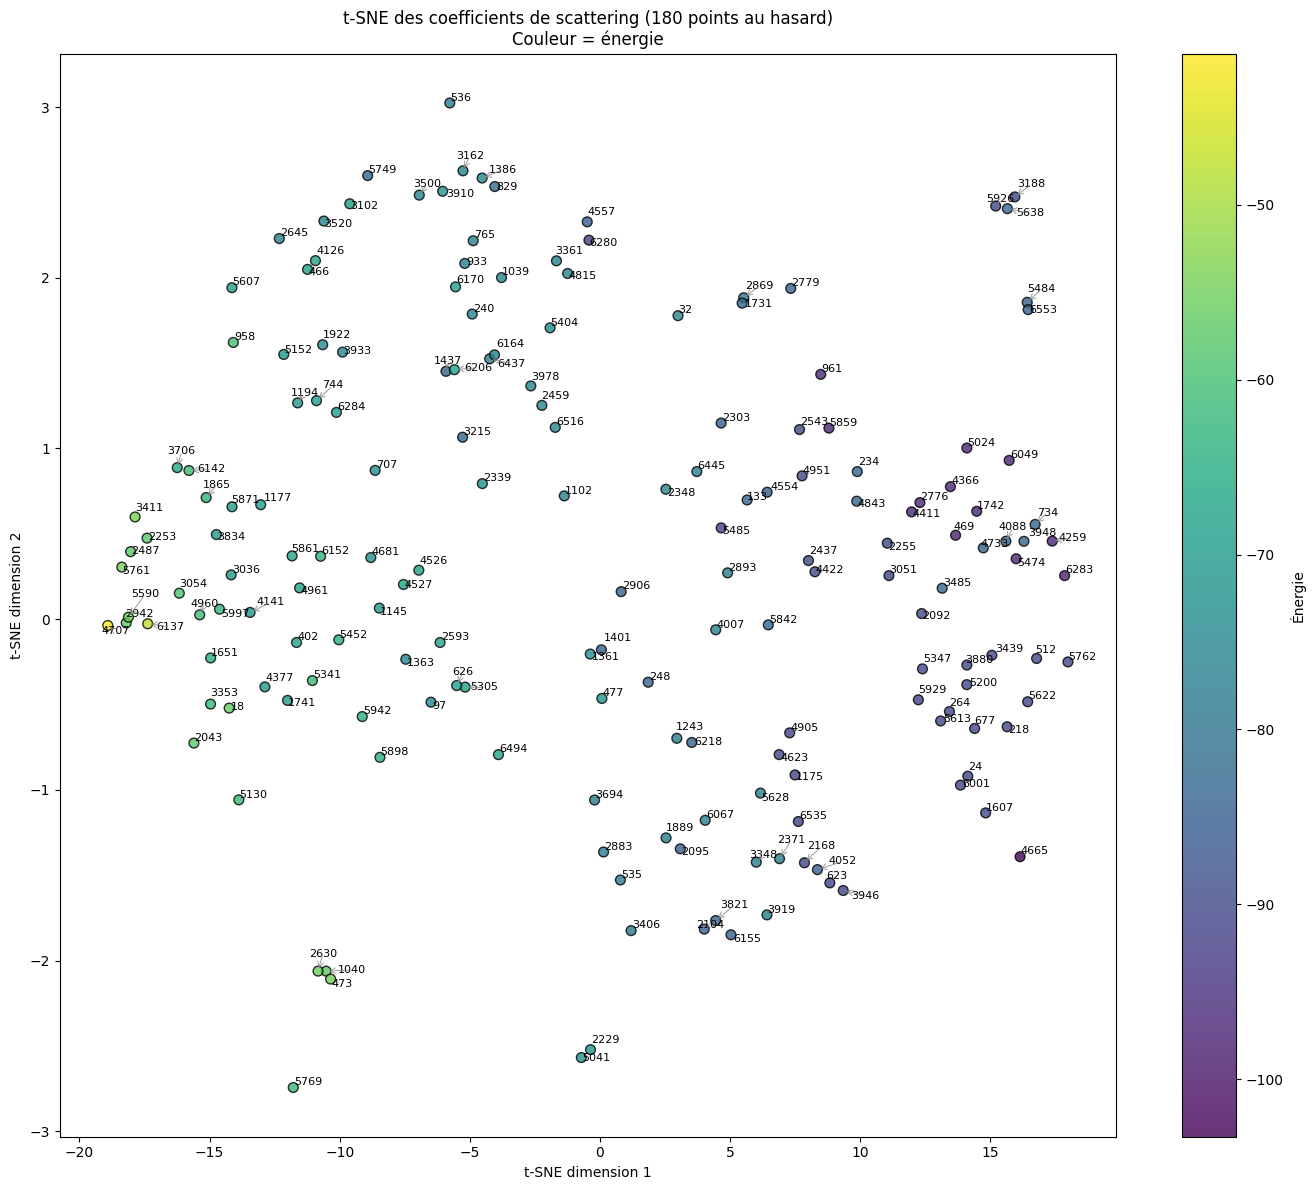

In [14]:



plot_scattering_tsne(orders_1_and_2_train, energies_train, ids_train, num_points=180, random_state=42)

## Performing Ridge Regression

Ridge Cv Manuel

In [15]:


# Appel de la fonction :
scaler, ridge_final, results_df, best_alpha, mse_val = ridge_cv_manual(X_Train_With_Features, energies_train    , nb_folds=5, alphas=np.logspace(-5, 5, 100), random_state=42)


Alphas: 100%|██████████| 100/100 [02:27<00:00,  1.48s/it]


📊 Tableau des MSE pour chaque alpha et chaque fold (trié par Mean MSE croissant) :


,Alpha,Mean MSE,MSE_Fold_1,MSE_Fold_2,MSE_Fold_3,MSE_Fold_4,MSE_Fold_5
40,0.109750,0.039332,0.037523,0.038138,0.038779,0.048590,0.033630
39,0.086975,0.039858,0.037361,0.036097,0.046529,0.047099,0.032202
41,0.138489,0.042221,0.038142,0.040388,0.046989,0.050257,0.035328
38,0.068926,0.044649,0.037648,0.034260,0.074560,0.045776,0.031002
42,0.174753,0.047441,0.039218,0.042847,0.065702,0.052109,0.037328
...,...,...,...,...,...,...,...
4,0.000025,35.729102,0.073274,0.011149,178.495374,0.047198,0.018517
3,0.000020,44.243277,0.062005,0.010806,221.077820,0.047473,0.018283
2,0.000016,54.177931,0.051900,0.010497,270.760921,0.048314,0.018022
1,0.000013,65.684813,0.043620,0.010222,328.302400,0.050081,0.017743



✅ Meilleur alpha trouvé : 0.109750
✅ Mean Squared Error on Validation Set (avec meilleur alpha) : 0.0222


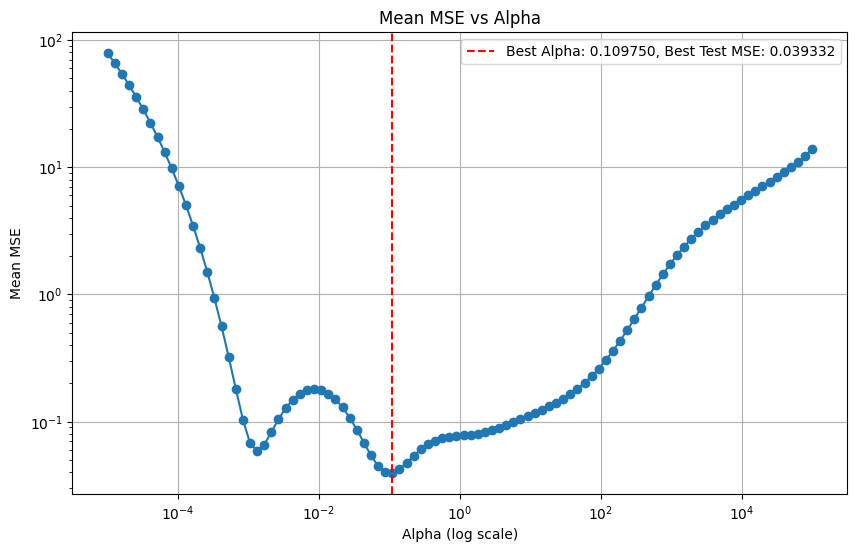

Best Mean MSE: 0.039332


In [21]:
def plot_ridge_cv_results(results_df, best_alpha):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 6))
    plt.plot(results_df['Alpha'], results_df['Mean MSE'], marker='o')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Alpha (log scale)')
    plt.ylabel('Mean MSE')
    plt.title('Mean MSE vs Alpha')
    plt.grid(True)
    plt.axvline(x=best_alpha, color='r', linestyle='--', label=f'Best Alpha: {best_alpha:.6f}, Best Test MSE: {results_df["Mean MSE"].min():.6f}')
    plt.legend()
    plt.show()
    best_loss = results_df['Mean MSE'].min()
    print(f"Best Mean MSE: {best_loss:.6f}")



# trier le results_df par alpha
results_df = results_df.sort_values(by='Alpha')
# Appel de la fonction
plot_ridge_cv_results(results_df, best_alpha)


# Prediction on Test Data

In [17]:

# Appel de la fonction
predictions_df = predict_and_save_test_energies(
    X_Test_With_Features, scaler, ridge_final, Ids_test, '../../Saved_Predictions/Scattering/predictions.csv'
)


ID: 6592, Predicted Energy: -90.4700
ID: 6593, Predicted Energy: -96.4239
ID: 6594, Predicted Energy: -67.8163
ID: 6595, Predicted Energy: -55.2926
ID: 6596, Predicted Energy: -84.7264
ID: 6597, Predicted Energy: -90.1284
ID: 6598, Predicted Energy: -76.2826
ID: 6599, Predicted Energy: -96.8790
ID: 6600, Predicted Energy: -84.8580
ID: 6601, Predicted Energy: -66.4570
ID: 6602, Predicted Energy: -77.1100
ID: 6603, Predicted Energy: -74.8820
ID: 6604, Predicted Energy: -84.3536
ID: 6605, Predicted Energy: -90.2485
ID: 6606, Predicted Energy: -78.8100
ID: 6607, Predicted Energy: -90.6382
ID: 6608, Predicted Energy: -83.5832
ID: 6609, Predicted Energy: -69.5150
ID: 6610, Predicted Energy: -84.5397
ID: 6611, Predicted Energy: -84.4072
ID: 6612, Predicted Energy: -83.2922
ID: 6613, Predicted Energy: -83.8012
ID: 6614, Predicted Energy: -90.4532
ID: 6615, Predicted Energy: -90.3262
ID: 6616, Predicted Energy: -90.2988
ID: 6617, Predicted Energy: -74.1265
ID: 6618, Predicted Energy: -58.0520
I

# Practical Proof of the Invariance

In [18]:
def config(device):
    M = 192
    N = 128
    O = 96
    grid  = torch.tensor(np.fft.ifftshift(np.mgrid[-M//2:-M//2+M, -N//2:-N//2+N, -O//2:-O//2+O]))
    
    J =2
    L = 3
    sigma = 2.0
    integral_powers = [0.5, 1.0, 2.0, 3.0,5.0]
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    scattering = HarmonicScattering3D(J=J, shape=(M, N, O),
                                        L=L, sigma_0=sigma,
                                        integral_powers=integral_powers, max_order=2).to(device)
    
    return grid, scattering, sigma, integral_powers, M,N,O,J,L


=== Scattering Translation Invariance Test Report (16:36:15 2025-06-29) ===
Molecule ID: 5317

+-------------------------------------+--------------+
|               Metric                |    Value     |
+-------------------------------------+--------------+
|    Max Relative Error (Order 0)     | 6.941017e-07 |
| Max Relative Error (Orders 1 and 2) | 2.099765e-04 |
|          Invariance Check           |     PASS     |
+-------------------------------------+--------------+

Translation Vector:
+------+-----------+
| Axis |   Value   |
+------+-----------+
|  X   | 0.308068  |
|  Y   | -0.179275 |
|  Z   | 0.062429  |
+------+-----------+

Atom Position Comparison (Part 1: Original Positions):
+----+-----------+-----------+-----------+
|    |   X_old   |   Y_old   |   Z_old   |
+----+-----------+-----------+-----------+
| 1  | -0.417915 | -1.348723 | -2.281501 |
| 2  | -0.521688 | -0.440716 | -1.062276 |
| 3  | 0.814494  | -0.310604 | -0.322175 |
| 4  | 0.783721  | 0.506577  | 0.9670

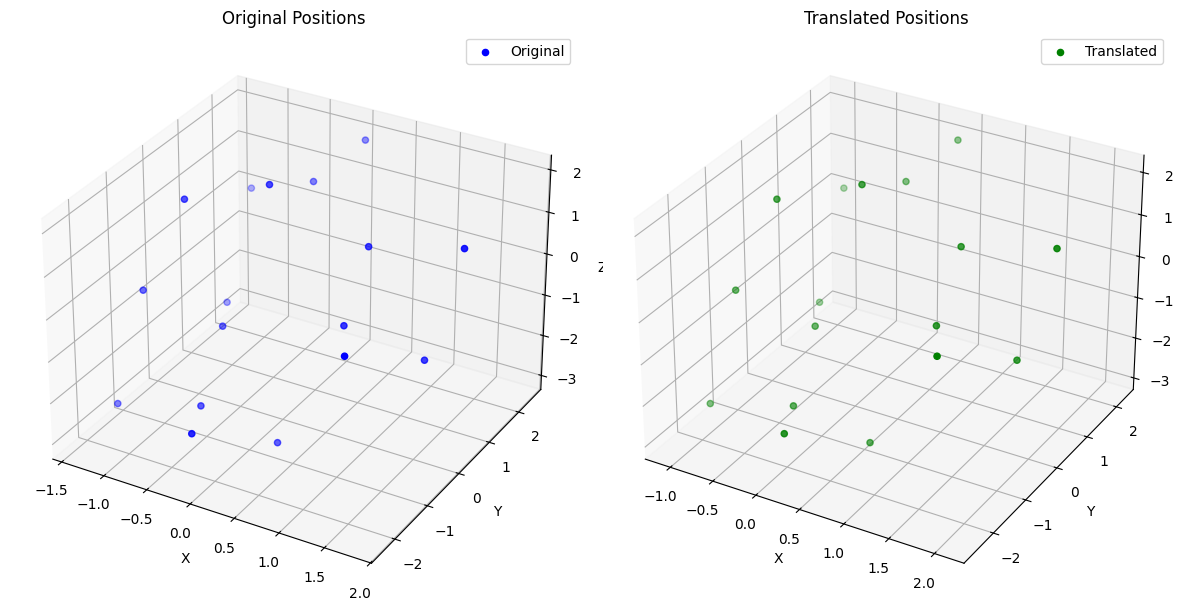


=== End of Report ===

Final Result: PASS


In [19]:


# Exemple d'utilisation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
grid, scattering, sigma, integral_powers, M, N, O, J, L = config(device)  # Fonction config de ton premier code
index_to_test = np.random.randint(0, len(List_Data_Train))
invariance_check, order_0_rel_error, orders_1_and_2_rel_error = test_scattering_translation_invariance(
    List_Data_Train, 
    index_to_test, 
    device, 
    grid, 
    scattering, 
    sigma, 
    integral_powers, 
    plot_positions=True,
    relative_error_threshold=1e-3
)

# Afficher le résultat final
print(colored(f"\nFinal Result: {invariance_check}", 'green' if invariance_check == "PASS" else 'red', attrs=['bold']))


=== Scattering Rotation Invariance Test Report (16:37:54 2025-06-29) ===
Molecule ID: 4517

+-------------------------------------+--------------+
|               Metric                |    Value     |
+-------------------------------------+--------------+
|    Max Relative Error (Order 0)     | 3.987890e-07 |
| Max Relative Error (Orders 1 and 2) | 1.347913e-02 |
|          Invariance Check           |     FAIL     |
+-------------------------------------+--------------+

Rotation Details:
+-------------------+-----------------------------------+
|     Parameter     |               Value               |
+-------------------+-----------------------------------+
| Point A (X, Y, Z) | (-0.493018, -0.096519, -0.265246) |
| Point B (X, Y, Z) |  (0.318869, -0.162669, 0.327524)  |
|  Angle (degrees)  |             90.000000             |
+-------------------+-----------------------------------+

Atom Pairwise Distances (Original, Rotated, Difference):
+-----------+--------------+-----------

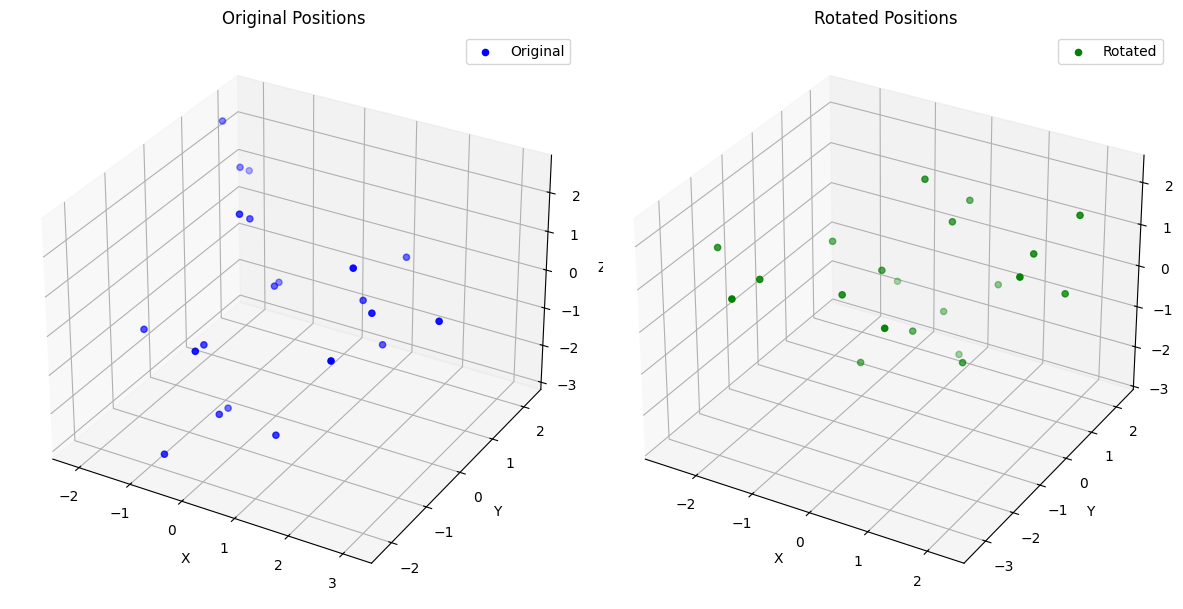


=== End of Report ===

Final Result: FAIL


In [22]:
# Empty Cash
torch.cuda.empty_cache()
# Exemple d'utilisation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
grid, scattering, sigma, integral_powers, M, N, O, J, L = config(device)  # Fonction config
index_to_test = np.random.randint(0, len(List_Data_Train))
invariance_check, order_0_rel_error, orders_1_and_2_rel_error = test_scattering_rotation_invariance(
    List_Data_Train, 
    index_to_test, 
    device, 
    grid, 
    scattering, 
    sigma, 
    integral_powers, 
    plot_positions=True,
    relative_error_threshold=1e-3
)

# Afficher le résultat final
print(colored(f"\nFinal Result: {invariance_check}", 'green' if invariance_check == "PASS" else 'red', attrs=['bold']))